In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
transactions = pd.read_csv('transactions.csv',index_col=[0])
transactions

,person,event,time,amount,gender,age,income,year joined,member_since(in years),gender_F,gender_M,gender_O,income bins,num_transactions
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,F,20,30000.0,2016,4,1,0,0,1,10
1,02c083884c7d45b39cc68e1314fec56c,transaction,6,1.44,F,20,30000.0,2016,4,1,0,0,1,10
2,02c083884c7d45b39cc68e1314fec56c,transaction,12,4.56,F,20,30000.0,2016,4,1,0,0,1,10
3,02c083884c7d45b39cc68e1314fec56c,transaction,84,1.53,F,20,30000.0,2016,4,1,0,0,1,10
4,02c083884c7d45b39cc68e1314fec56c,transaction,90,0.50,F,20,30000.0,2016,4,1,0,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123797,aabc3d56a2ea4446bef4c3f9eec8ab72,transaction,714,14.68,F,72,74000.0,2018,2,1,0,0,3,1
123798,448dabde725040978b8a247a20bac126,transaction,714,3.19,M,50,60000.0,2018,2,0,1,0,2,1
123799,7718656997f3453db0f5aeca9cd35240,transaction,714,15.35,F,73,65000.0,2018,2,1,0,0,3,1
123800,54463e5d95124b7fb3133fc1eae71952,transaction,714,0.76,M,42,69000.0,2017,3,0,1,0,3,1


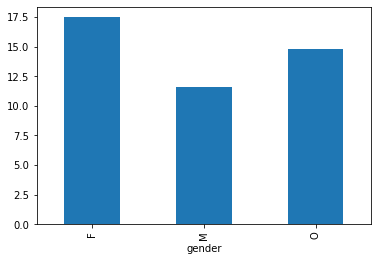

In [3]:
gender = transactions.groupby('gender')['amount'].mean()
gender.plot(kind='bar')

In [4]:
type(gender)

pandas.core.series.Series

In [5]:
gender = pd.DataFrame(gender)
gender

,amount
gender,
F,17.488521
M,11.603045
O,14.778887


In [6]:
gender['percent'] = (gender['amount'] / gender['amount'].sum()) * 100
gender

,amount,percent
gender,,
F,17.488521,39.864007
M,11.603045,26.448428
O,14.778887,33.687564


In [7]:
transactions['gender'].value_counts()

M    72770
F    49262
O     1770
Name: gender, dtype: int64

Since transactions is a sample dataset and we have observed differences in mean amount soent by each gender, we will now perform anova test to check is this difference is significant in population also.

For testing we need similar sample sizes for each group. So we will select 1770 samples from each group as there are only 1770 samples in other gender group. We will select observations randomly from male and female groups using sample function.

In [8]:
male_sample = transactions[transactions['gender'] == 'M'].sample(n=1770, random_state=42)[['gender','amount']]
female_sample = transactions[transactions['gender'] == 'F'].sample(n=1770, random_state=42)[['gender','amount']]
other_gender_sample = transactions[transactions['gender']=='O'][['gender','amount']]

ab_test = pd.concat([male_sample, female_sample,other_gender_sample], axis=0)
ab_test.reset_index(drop=True,inplace=True)
ab_test

,gender,amount
0,M,11.47
1,M,14.11
2,M,4.21
3,M,28.47
4,M,8.35
...,...,...
5305,O,20.07
5306,O,34.40
5307,O,19.96
5308,O,31.06


In [9]:
ab_test['gender'].value_counts()

O    1770
F    1770
M    1770
Name: gender, dtype: int64

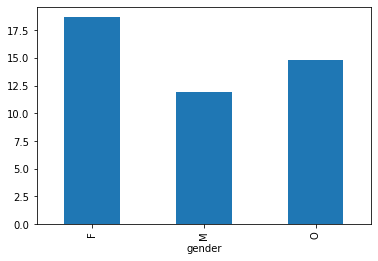

In [10]:
amount = ab_test.groupby('gender')['amount'].mean()
amount.plot(kind='bar')
# mean of amount spent by each gender from sample data.

In [11]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Ordinary Least Squares (OLS) model
model = ols('amount ~ C(gender)', data=ab_test).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(gender),4.054291e+04,2.0,18.292425,1.210482e-08
Residual,5.881157e+06,5307.0,NaN,NaN


Since the p value (1.210482e-08) is less than alpha (0.05) we can conclude that there is significant difference in mean amount spent by all the three genders.

In [13]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=ab_test, res_var='amount', xfac_var='gender', anova_model='amount ~ C(gender)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,M,F,6.739492,4.116109,9.362874,8.517398,0.001000
1,M,O,2.828599,0.205216,5.451981,3.574795,0.030913
2,F,O,3.910893,1.287510,6.534275,4.942603,0.001388


As you can see the difference in female and male is high comparatively. 

Now as we saw results from anova test that the mean amount of all three gender's are not equal and from tukey HSD test we came to know that females spend more than other genders and males spend least of all, we can make few changes in the offers given to males such as increase the rewards for converting the offer and for females we can give more offers which could lead to more conversions.

In [14]:
transactions['num_transactions'].value_counts()

8     9072
10    8870
7     8211
11    8162
6     7950
9     7749
12    7692
13    7449
5     6845
14    6580
15    5610
16    5392
4     5320
17    4522
18    4320
19    3344
3     3159
20    2660
21    2373
22    2178
23    1426
2     1346
25     975
24     840
26     390
1      319
27     297
29     203
28     196
30     150
36      72
32      64
35      35
31      31
Name: num_transactions, dtype: int64

In [16]:
num_transactions = transactions.groupby('gender')['num_transactions'].mean()
num_transactions

gender
F    10.931387
M    12.007503
O    11.681356
Name: num_transactions, dtype: float64

num_transactions is the number of transactions that a customer makes for an offer. We can see that it is almost same for all the three genders. We will perform A/B testing to verify it for population data.

In [17]:
# choosing equal number of samples for all three genders

male_sample = transactions[transactions['gender'] == 'M'].sample(n=1770, random_state=42)[['gender','num_transactions']]
female_sample = transactions[transactions['gender'] == 'F'].sample(n=1770, random_state=42)[['gender','num_transactions']]
other_gender_sample = transactions[transactions['gender']=='O'][['gender','num_transactions']]

ab_test = pd.concat([male_sample, female_sample,other_gender_sample], axis=0)
ab_test.reset_index(drop=True,inplace=True)
ab_test

,gender,num_transactions
0,M,8
1,M,11
2,M,22
3,M,13
4,M,7
...,...,...
5305,O,3
5306,O,3
5307,O,3
5308,O,2


gender
F    10.902260
M    11.915819
O    11.681356
Name: num_transactions, dtype: float64


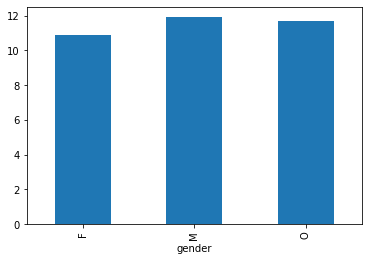

In [25]:
amount = ab_test.groupby('gender')['num_transactions'].mean()
print(amount)
amount.plot(kind='bar')
# mean of amount spent by each gender from sample data.

In [20]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Ordinary Least Squares (OLS) model
model = ols('num_transactions ~ C(gender)', data=ab_test).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(gender),996.667043,2.0,16.80589,5.300427e-08
Residual,157364.832768,5307.0,NaN,NaN


As the p-value is less than alpha(0.05) we can conclude than the mean number of transactions are not equal for all the three genders. We will now see a detailed picture using tukey HSD.

In [24]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=ab_test, res_var='num_transactions', xfac_var='gender', anova_model='num_transactions ~ C(gender)',phalpha=0.05)
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,M,F,1.013559,0.584434,1.442685,7.830807,0.001000
1,M,O,0.234463,-0.194662,0.663589,1.811474,0.407703
2,F,O,0.779096,0.349971,1.208221,6.019333,0.001000


As you can see the p values for Male, Female and Female, Other gender are less, their means are not equal. But the p value for Male and other gender is 0.407 which is greater than 0.05. So we conclude that the mean number of transaction for Male and other gender are equal with 95 percent confidance.

In [1]:
# Anova assumes that the distribution of continuous feature is normally distributed and have equal variances for each category 